# Connect 4 Final Notebook

In [1]:
TRAIN_MODEL = False

## Imports and Set-Up

In [2]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
from copy import deepcopy
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, HTML
import time
import io
import re
import tempfile
from contextlib import suppress
import os
import sympy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
print("Using device:", device)
if device.type == "cuda":
    print("CUDA device name:", torch.cuda.get_device_name(0))

False
Using device: cpu


In [6]:
!which ffmpeg || echo "FFmpeg not found!" # else install it using e.g. brew install ffmpeg

/opt/homebrew/bin/ffmpeg


In [7]:
def to_device(tensor):
    return tensor.to(device)

## Connect4 Environment

In [8]:
class Connect4Env:
    def __init__(self):
        self.rows = 6
        self.cols = 7
        self.reset()

    def reset(self):
        self.board = np.zeros((self.rows, self.cols), dtype=int)
        self.current_player = 1
        self.last_move = None
        return self._get_obs()

    def _get_obs(self):
        p1_board = (self.board == 1).astype(np.float32)
        p2_board = (self.board == -1).astype(np.float32)
        if self.current_player == 1:
            return np.stack([p1_board, p2_board], axis=0)
        else:
            return np.stack([p2_board, p1_board], axis=0)

    def _count_diagonal_threats(self, player):
        """Count potential diagonal winning threats (3-in-a-row with space)"""
        threat_count = 0

        # Check diagonal down-right threats
        for r in range(self.rows - 3):
            for c in range(self.cols - 3):
                # Get the diagonal
                diagonal = [self.board[r+i, c+i] for i in range(4)]
                # Count if we have 3 of our pieces and 1 empty
                if diagonal.count(player) == 3 and diagonal.count(0) == 1:
                    threat_count += 1

        # Check diagonal up-right threats
        for r in range(3, self.rows):
            for c in range(self.cols - 3):
                # Get the diagonal
                diagonal = [self.board[r-i, c+i] for i in range(4)]
                # Count if we have 3 of our pieces and 1 empty
                if diagonal.count(player) == 3 and diagonal.count(0) == 1:
                    threat_count += 1

        return threat_count

    def valid_actions(self):
        return [c for c in range(self.cols) if self.board[0, c] == 0]

    def step(self, action):
        if action not in self.valid_actions():
            return self._get_obs(), -10, True, {}

        # Find where the piece lands
        for r in range(self.rows - 1, -1, -1):
            if self.board[r, action] == 0:
                self.board[r, action] = self.current_player
                self.last_move = (r, action)
                break

        # Add strategic reward based on board evaluation
        intermediate_reward = self._evaluate_board_state(self.current_player, action)

        # Check for win - INCREASED REWARD SIGNIFICANTLY
        if self._check_winner(self.current_player, self.last_move):
            return self._get_obs(), 5.0 + intermediate_reward, True, {}  # Increased from 1.0 to 5.0

        # Check for draw
        if len(self.valid_actions()) == 0:
            return self._get_obs(), 0 + intermediate_reward, True, {}

        # Small penalty for each move to encourage faster wins
        self.current_player *= -1
        return self._get_obs(), -0.01 + intermediate_reward, False, {}


    def _check_winner(self, player, last_move):
        if last_move is None:
            return False
        r, c = last_move
        directions = [(1, 0), (0, 1), (1, 1), (1, -1)]
        for dr, dc in directions:
            count = 1
            for d in [-1, 1]:
                nr, nc = r + d * dr, c + d * dc
                while 0 <= nr < self.rows and 0 <= nc < self.cols and self.board[nr, nc] == player:
                    count += 1
                    if count >= 4:
                        return True
                    nr += d * dr
                    nc += d * dc
        return False

    def is_critical_position(self):
        """
        Determine if the current board position is strategically critical
        - Positions where a win is possible in 1-2 moves
        - Positions requiring blocking
        - Positions with multiple threats

        Returns:
            Boolean indicating if position is critical
        """
        current_player = self.current_player
        opponent = -current_player

        # Check if current player can win in 1 move
        for action in self.valid_actions():
            # Make temporary move
            original_board = self.board.copy()
            row = None
            for r in range(self.rows - 1, -1, -1):
                if self.board[r, action] == 0:
                    self.board[r, action] = current_player
                    row = r
                    break

            if row is not None:
                # Check if this wins
                if self._check_winner(current_player, (row, action)):
                    self.board = original_board
                    return True
                self.board = original_board

        # Check if opponent can win in 1 move (blocking needed)
        for action in self.valid_actions():
            # Make temporary move
            original_board = self.board.copy()
            row = None
            for r in range(self.rows - 1, -1, -1):
                if self.board[r, action] == 0:
                    self.board[r, action] = opponent
                    row = r
                    break

            if row is not None:
                # Check if this wins for opponent
                if self._check_winner(opponent, (row, action)):
                    self.board = original_board
                    return True
                self.board = original_board

        # Check for fork opportunities (multiple threats)
        if self._evaluate_fork_potential(current_player) > 0:
            return True

        # Check for multiple potential threats
        if self._count_consecutive(current_player, 3) >= 2:
            return True
        if self._count_consecutive(current_player, 2) >= 3:
            return True

        return False

    def _evaluate_board_state(self, player, action):
        """Enhanced reward function with better strategic understanding and stricter column stacking prevention"""
        reward = 0

        # Get opponent
        opponent = -player

        # 1. Reward for creating potential winning sequences - weighted by length
        reward += self._count_consecutive(player, 2) * 0.02  # Two in a row
        reward += self._count_consecutive(player, 3) * 0.2   # Three in a row (much more valuable)

        # 2. Reward for blocking opponent's potential win
        opponent_threes = self._count_consecutive(opponent, 3)
        reward += self._count_blocking_moves(opponent) * 0.3

        # 3. Better center column control evaluation - weighted by row
        center_col = self.cols // 2
        center_control = 0
        for r in range(self.rows):
            if self.board[r, center_col] == player:
                # Weight increases as you get lower in the board
                row_weight = (self.rows - r) / self.rows
                center_control += row_weight * 0.05
        reward += center_control

        # 4. Reward for creating "forks" - multiple threats simultaneously
        fork_value = self._evaluate_fork_potential(player)
        reward += fork_value * 0.3

        # 5. Penalize moves that allow opponent to win next turn
        if self._opponent_can_win_next_move(opponent):
            reward -= 1.0

        # 6. ENHANCED: Severely penalize excessive column stacking
        pieces_in_column = 0
        for r in range(self.rows):
            if self.board[r, action] != 0:
                pieces_in_column += 1

        # Calculate what percentage of the column is filled
        column_fill_percentage = pieces_in_column / self.rows

        # Progressive penalty that increases exponentially
        if column_fill_percentage > 0.33:  # Start penalty earlier (was 0.5)
            # Cubic penalty growth instead of quadratic
            stacking_penalty = 0.2 * ((column_fill_percentage - 0.33) ** 3) * 5.0
            reward -= stacking_penalty

        # 7. NEW: Penalize imbalanced play across columns
        # Count pieces in each column
        col_counts = [sum(1 for r in range(self.rows) if self.board[r, c] == player) for c in range(self.cols)]

        # Check for highly imbalanced play (too many pieces in some columns, none in others)
        if max(col_counts) > 0 and sum(1 for c in col_counts if c == 0) >= 3:
            # Penalize having 3+ empty columns while stacking in others
            reward -= 0.15

        # 8. NEW: Reward for distributed play
        columns_used = sum(1 for c in range(self.cols) if any(self.board[r, c] == player for r in range(self.rows)))
        distribution_reward = 0.03 * columns_used / self.cols  # Increased from 0.02
        reward += distribution_reward

        # 9. NEW: Reward diagonal threats more (these are harder for humans to spot)
        diagonal_threats = self._count_diagonal_threats(player)
        reward += diagonal_threats * 0.05

        return reward

    def _evaluate_fork_potential(self, player):
        """Count how many ways the player can create multiple threats"""
        fork_count = 0

        # Check each valid action
        for action in self.valid_actions():
            # Make a copy of the board
            test_board = self.board.copy()

            # Find where the piece would land
            for r in range(self.rows - 1, -1, -1):
                if test_board[r, action] == 0:
                    test_board[r, action] = player
                    test_row, test_col = r, action
                    break

            # Check if this creates multiple threats
            threats = self._count_threats_at_position(test_board, player, test_row, test_col)
            if threats >= 2:
                fork_count += 1

        return fork_count

    def _count_threats_at_position(self, board, player, row, col):
        """Count how many winning threats exist from this position"""
        threat_count = 0
        directions = [(0, 1), (1, 0), (1, 1), (1, -1)]

        for dr, dc in directions:
            # Check both directions along this line
            for direction_mult in [-1, 1]:
                # Initialize counters for this direction
                consecutive = 1  # Start with 1 for the piece at (row, col)
                empty_spots = 0

                # Check 3 positions in this direction
                for i in range(1, 4):
                    r = row + direction_mult * i * dr
                    c = col + direction_mult * i * dc

                    # Check bounds
                    if 0 <= r < self.rows and 0 <= c < self.cols:
                        if board[r, c] == player:
                            consecutive += 1
                        elif board[r, c] == 0:
                            empty_spots += 1
                        else:
                            break  # Opponent's piece, stop checking
                    else:
                        break  # Out of bounds

                # If we have 3 pieces and an empty spot, it's a threat
                if consecutive == 3 and empty_spots == 1:
                    threat_count += 1

        return threat_count

    def _opponent_can_win_next_move(self, opponent):
        """Check if opponent can win on their next move"""
        for action in self.valid_actions():
            # Find where the piece would land
            for r in range(self.rows - 1, -1, -1):
                if self.board[r, action] == 0:
                    # Try placing opponent's piece here
                    self.board[r, action] = opponent

                    # Check if this results in a win
                    if self._check_winner(opponent, (r, action)):
                        # Undo the move
                        self.board[r, action] = 0
                        return True

                    # Undo the move
                    self.board[r, action] = 0
                    break

        return False

    def _count_blocking_moves(self, opponent):
        """Count how many potential winning sequences of the opponent we're blocking"""
        block_count = 0

        # Try each valid move
        for action in self.valid_actions():
            # Find where the piece would land
            for r in range(self.rows - 1, -1, -1):
                if self.board[r, action] == 0:
                    # Check if opponent placing here would result in a win
                    self.board[r, action] = opponent
                    if self._check_winner(opponent, (r, action)):
                        block_count += 1

                    # Undo the move
                    self.board[r, action] = 0
                    break

        return block_count

    def _count_consecutive(self, player, length):
        """Count how many potential n-in-a-row patterns exist for a player"""
        count = 0

        # Check horizontal, vertical, and both diagonal directions
        directions = [(0, 1), (1, 0), (1, 1), (1, -1)]

        for r in range(self.rows):
            for c in range(self.cols):
                for dr, dc in directions:
                    if (0 <= r + (length-1)*dr < self.rows and
                        0 <= c + (length-1)*dc < self.cols):

                        # Get sequence
                        sequence = [self.board[r + i*dr, c + i*dc] for i in range(length)]

                        # Check if this sequence has exactly 'length-1' of player's pieces and rest empty
                        if sequence.count(player) == length - 1 and sequence.count(0) == 1:
                            count += 1

        return count

    def _check_win_at_position(self, board, player, row, col):
        """Check if placing a piece at (row, col) would result in a win"""
        directions = [(0, 1), (1, 0), (1, 1), (1, -1)]

        for dr, dc in directions:
            count = 1  # Start with 1 for the piece at (row, col)

            # Check both directions along this line
            for d in [-1, 1]:
                r, c = row + d*dr, col + d*dc
                while 0 <= r < self.rows and 0 <= c < self.cols and board[r, c] == player:
                    count += 1
                    if count >= 4:
                        return True
                    r += d*dr
                    c += d*dc

        return False

    def get_game_phase(self):
        """Determine the current phase of the game"""
        filled_count = np.count_nonzero(self.board)
        total_cells = self.rows * self.cols
        fill_percentage = filled_count / total_cells

        if fill_percentage < 0.25:
            return "opening"
        elif fill_percentage < 0.6:
            return "midgame"
        else:
            return "endgame"

## MODEL and TRAINING functions

Model

In [9]:
class EnhancedDQN(nn.Module):
    def __init__(self):
        super().__init__()
        # More filters and deeper network
        self.conv1 = nn.Conv2d(2, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Add residual connections - CORRECTED: should adapt from 64 to 128 channels
        self.res_conv1 = nn.Conv2d(64, 128, kernel_size=1)
        self.res_bn1 = nn.BatchNorm2d(128)

        # Value and advantage streams (Dueling DQN architecture)
        self.value_stream = nn.Sequential(
            nn.Linear(128 * 6 * 7, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

        self.advantage_stream = nn.Sequential(
            nn.Linear(128 * 6 * 7, 256),
            nn.ReLU(),
            nn.Linear(256, 7)
        )

        # Dropout for regularization
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.to(device)

        # First convolutional block
        x = F.relu(self.bn1(self.conv1(x)))

        # Store the output after first conv as residual (now has 64 channels)
        residual = x

        # Second block with residual connection
        x = F.relu(self.bn2(self.conv2(x)))
        # Apply res_conv1 to adapt channel dimensions (64->128)
        residual = self.res_bn1(self.res_conv1(residual))
        x = F.relu(self.bn3(self.conv3(x)) + residual)

        # Flatten
        x = x.view(x.size(0), -1)
        x = self.dropout(x)

        # Dueling architecture
        value = self.value_stream(x)
        advantage = self.advantage_stream(x)

        # Combine streams
        q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))

        return q_values

Replay Buffers

In [10]:
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, transition):
        if len(self.buffer) < self.capacity:
            self.buffer.append(transition)
        else:
            self.buffer[self.position] = transition
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        if len(self.buffer) < batch_size:
            return random.sample(self.buffer, len(self.buffer))
        else:
            return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

In [11]:
# Prioritized Replay Buffer implementation
class PrioritizedReplayBuffer:
    def __init__(self, capacity=10000, alpha=0.6, beta=0.4, beta_increment=0.001):
        self.capacity = capacity
        self.alpha = alpha  # How much prioritization to use (0 = none, 1 = full)
        self.beta = beta    # Importance sampling correction (starts low, anneals to 1)
        self.beta_increment = beta_increment
        self.buffer = []
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.position = 0
        self.size = 0

    def push(self, transition, priority=None):
        if priority is None:
            priority = 1.0 if self.size == 0 else self.priorities[:self.size].max()

        if self.size < self.capacity:
            self.buffer.append(transition)
            self.size += 1
        else:
            self.buffer[self.position] = transition

        self.priorities[self.position] = priority ** self.alpha
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        if self.size < batch_size:
            indices = np.random.choice(self.size, self.size, replace=False)
        else:
            # Calculate sampling probabilities from priorities
            probs = self.priorities[:self.size] / self.priorities[:self.size].sum()

            # Sample indices based on priorities
            indices = np.random.choice(self.size, batch_size, replace=False, p=probs)

        samples = [self.buffer[idx] for idx in indices]

        # Calculate importance sampling weights
        weights = (self.size * probs[indices]) ** -self.beta
        weights /= weights.max()  # Normalize to max weight = 1

        # Increase beta toward 1 for less correction over time
        self.beta = min(1.0, self.beta + self.beta_increment)

        return samples, indices, weights

    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority ** self.alpha

    def __len__(self):
        return self.size

Selecting Action

In [12]:
def select_action(model, state, epsilon, valid_actions):
    if random.random() < epsilon:
        return random.choice(valid_actions)
    else:
        with torch.no_grad():
            # Ensure state has the right dimensions and type
            if isinstance(state, np.ndarray):
                state_tensor = torch.tensor(state, dtype=torch.float32)
            else:
                state_tensor = state.clone().detach()

            # Make sure it's the right shape [batch, channels, height, width]
            if state_tensor.dim() == 3:  # If [channels, height, width]
                state_tensor = state_tensor.unsqueeze(0)  # Add batch dimension

            # Send to device
            state_tensor = state_tensor.to(device)

            # Get Q-values from model
            q_values = model(state_tensor)
            q_values = q_values.squeeze()

            # Mask invalid actions with negative infinity
            invalid_indices = [i for i in range(7) if i not in valid_actions]
            if invalid_indices:
                q_values[invalid_indices] = -float('inf')

            return torch.argmax(q_values).item()

Utilities

In [13]:
# Add these functions at the module level, alongside your other utility functions
# (Same level as select_action, ReplayBuffer, etc.)

def check_for_win(env, action, player):
    """
    Check if placing a piece by player in the given column results in a win

    Args:
        env: Connect4Env instance
        action: Column to place the piece (0-6)
        player: Player making the move (1 or -1)

    Returns:
        Boolean indicating if this move wins
    """
    # Make a copy of the board
    original_board = env.board.copy()
    original_player = env.current_player

    # Find the row where the piece would land
    row = None
    for r in range(env.rows - 1, -1, -1):
        if env.board[r, action] == 0:
            # Place the piece
            env.board[r, action] = player
            row = r
            break

    # If column is full, return False
    if row is None:
        env.board = original_board
        return False

    # Check if this creates a win
    position = (row, action)
    win = env._check_winner(player, position)

    # Restore the board
    env.board = original_board
    env.current_player = original_player

    return win

def check_for_win_in_two(env, action, player):
    """
    Check if placing a piece creates a forced win in the next move
    (Win-in-two detection)

    Args:
        env: Connect4Env instance
        action: Column to place the piece (0-6)
        player: Player making the move (1 or -1)

    Returns:
        Boolean indicating if this move creates a forced win next turn
    """
    # Make a copy of the board
    original_board = env.board.copy()
    original_player = env.current_player

    # Find the row where the piece would land
    row = None
    for r in range(env.rows - 1, -1, -1):
        if env.board[r, action] == 0:
            # Place the piece
            env.board[r, action] = player
            row = r
            break

    # If column is full, return False
    if row is None:
        env.board = original_board
        return False

    # Check if this already wins (win-in-one)
    if env._check_winner(player, (row, action)):
        env.board = original_board
        env.current_player = original_player
        return True

    # Check if we can create a position with two winning threats
    # that cannot both be blocked in one move
    winning_columns = []

    # Check each column for potential winning moves next turn
    for next_action in range(env.cols):
        # Skip if column is full
        if env.board[0, next_action] != 0:
            continue

        # Find where piece would land
        next_row = None
        for r in range(env.rows - 1, -1, -1):
            if env.board[r, next_action] == 0:
                next_row = r
                break

        # Place piece and check for win
        env.board[next_row, next_action] = player
        if env._check_winner(player, (next_row, next_action)):
            winning_columns.append(next_action)

        # Remove the piece
        env.board[next_row, next_action] = 0

    # Restore the board
    env.board = original_board
    env.current_player = original_player

    # If we have two or more winning columns, this is a forced win
    # (opponent can only block one)
    return len(winning_columns) >= 2

def find_winning_move(env, player):
    """
    Find a winning move for the given player

    Args:
        env: Connect4Env instance
        player: Player to find winning move for (1 or -1)

    Returns:
        Column index of winning move, or None if no winning move exists
    """
    valid_actions = env.valid_actions()

    # First look for immediate wins
    for action in valid_actions:
        if check_for_win(env, action, player):
            return action

    # Then look for win-in-two setups
    for action in valid_actions:
        if check_for_win_in_two(env, action, player):
            return action

    return None

def find_blocking_move(env, player):
    """
    Find a move that blocks the opponent from winning on their next turn

    Args:
        env: Connect4Env instance
        player: Current player (1 or -1)

    Returns:
        Column index of blocking move, or None if no blocking move needed
    """
    opponent = -player
    valid_actions = env.valid_actions()

    # Check if opponent can win on their next move
    for action in valid_actions:
        if check_for_win(env, action, opponent):
            return action

    return None

def enhanced_select_action(model, state, env, epsilon=0.0):
    """
    Enhanced action selection that combines tactical awareness with RL

    Args:
        model: Trained RL model
        state: Current state representation
        env: Connect4Env instance
        epsilon: Exploration probability

    Returns:
        Selected action
    """
    # Get the current player
    current_player = env.current_player
    valid_actions = env.valid_actions()

    # If no valid actions, return None
    if not valid_actions:
        return None

    # STEP 1: Always check for winning moves first
    winning_move = find_winning_move(env, current_player)
    if winning_move is not None:
        return winning_move

    # STEP 2: Then check for blocking moves
    blocking_move = find_blocking_move(env, current_player)
    if blocking_move is not None:
        return blocking_move

    # STEP 3: If no critical moves, use the RL model with epsilon-greedy
    if random.random() < epsilon:
        return random.choice(valid_actions)
    else:
        with torch.no_grad():
            # Ensure state has the right dimensions and type
            if isinstance(state, np.ndarray):
                state_tensor = torch.tensor(state, dtype=torch.float32)
            else:
                state_tensor = state.clone().detach()

            # Make sure it's the right shape [batch, channels, height, width]
            if state_tensor.dim() == 3:  # If [channels, height, width]
                state_tensor = state_tensor.unsqueeze(0)  # Add batch dimension

            # Send to device
            state_tensor = state_tensor.to(device)

            # Get Q-values from model
            q_values = model(state_tensor)
            q_values = q_values.squeeze()

            # Mask invalid actions with negative infinity
            invalid_indices = [i for i in range(7) if i not in valid_actions]
            if invalid_indices:
                q_values[invalid_indices] = -float('inf')

            # Get top 3 actions and their values
            top_values, top_indices = torch.topk(q_values, min(3, len(valid_actions)))

            # Add a small amount of randomness to the top actions to make play more human-like
            # Small probability (10%) of picking the 2nd best move if it's close in value to the best
            if len(top_indices) > 1 and random.random() < 0.1 and (top_values[0] - top_values[1]) < 0.3:
                return top_indices[1].item()

            return top_indices[0].item()

Plot Training Metrics

In [14]:
# Metrics plotting function
def plot_training_metrics(metrics, episode):
    """Display training metrics in the console"""
    import matplotlib.pyplot as plt

    # Create figure with multiple subplots - added one more row for balance adjustments
    fig, axes = plt.subplots(4, 2, figsize=(15, 20))

    # Plot rewards
    axes[0, 0].plot(metrics['episode_rewards_p1'], label='Player 1')
    axes[0, 0].plot(metrics['episode_rewards_p2'], label='Player 2')
    axes[0, 0].set_title('Episode Rewards')
    axes[0, 0].set_xlabel('Episode')
    axes[0, 0].set_ylabel('Reward')
    axes[0, 0].legend()

    # Plot epsilon
    axes[0, 1].plot(metrics['epsilon_values'])
    axes[0, 1].set_title('Exploration Rate (Epsilon)')
    axes[0, 1].set_xlabel('Episode')
    axes[0, 1].set_ylabel('Epsilon')

    # Plot losses
    if len(metrics['losses']) > 0:
        # Smooth the losses for better visualization
        window_size = min(100, len(metrics['losses']))
        smoothed_losses = np.convolve(metrics['losses'], np.ones(window_size)/window_size, mode='valid')
        axes[1, 0].plot(smoothed_losses)
        axes[1, 0].set_title('Training Loss (Smoothed)')
        axes[1, 0].set_xlabel('Update Step')
        axes[1, 0].set_ylabel('Loss')
        axes[1, 0].set_yscale('log')

    # Plot win ratio
    if len(metrics['win_ratio']) > 0:
        axes[1, 1].plot(metrics['win_ratio'])
        axes[1, 1].set_title('Win Ratio (Player 1)')
        axes[1, 1].set_xlabel('100s of Episodes')
        axes[1, 1].set_ylabel('Win Ratio')

    # Plot column usage (as bar chart)
    normalized_usage = metrics['column_usage'] / np.sum(metrics['column_usage'])
    axes[2, 0].bar(range(len(normalized_usage)), normalized_usage)
    axes[2, 0].set_title('Column Usage Distribution')
    axes[2, 0].set_xlabel('Column')
    axes[2, 0].set_ylabel('Usage Frequency')
    axes[2, 0].set_xticks(range(len(normalized_usage)))

    # Plot game length
    if len(metrics['avg_game_length']) > 0:
        # Smooth game lengths
        window_size = min(100, len(metrics['avg_game_length']))
        smoothed_lengths = np.convolve(metrics['avg_game_length'], np.ones(window_size)/window_size, mode='valid')
        axes[2, 1].plot(smoothed_lengths)
        axes[2, 1].set_title('Average Game Length (Smoothed)')
        axes[2, 1].set_xlabel('Episode')
        axes[2, 1].set_ylabel('Steps')

    # NEW: Plot balance adjustments
    if 'balance_adjustments' in metrics and metrics['balance_adjustments']:
        # Extract data
        adj_episodes = [x[0] for x in metrics['balance_adjustments']]
        adj_win_rates = [x[1] for x in metrics['balance_adjustments']]

        # Plot win rates at adjustment points
        axes[3, 0].plot(adj_episodes, adj_win_rates, 'o-', label='P1 Win Rate')

        # Add horizontal lines at threshold values
        axes[3, 0].axhline(y=0.7, color='r', linestyle='--', label='P1 Dominance Threshold')
        axes[3, 0].axhline(y=0.3, color='g', linestyle='--', label='P2 Dominance Threshold')

        # Highlight balanced zone
        axes[3, 0].axhspan(0.3, 0.7, alpha=0.2, color='green', label='Balanced Zone')

        # Add labels for adjustments
        for i, (ep, rate) in enumerate(zip(adj_episodes, adj_win_rates)):
            if rate > 0.7:
                axes[3, 0].annotate('↓', xy=(ep, rate), xytext=(0, 5),
                                   textcoords='offset points', ha='center',
                                   fontsize=12, color='blue')
            elif rate < 0.3:
                axes[3, 0].annotate('↑', xy=(ep, rate), xytext=(0, 5),
                                   textcoords='offset points', ha='center',
                                   fontsize=12, color='red')

        axes[3, 0].set_title('Balance Adjustments')
        axes[3, 0].set_xlabel('Episode')
        axes[3, 0].set_ylabel('P1 Win Rate')
        axes[3, 0].set_ylim(0, 1)
        axes[3, 0].legend()

    # CURRICULUM
    if 'curriculum_phases' in metrics and metrics['curriculum_phases']:
        phases_x = [x[0] for x in metrics['curriculum_phases']]
        phases_y = [x[1] for x in metrics['curriculum_phases']]

        # Add starting point (episode 0, phase 0)
        if phases_x[0] > 0:
            phases_x = [0] + phases_x
            phases_y = [0] + phases_y

        # Add current point if not already in the list
        if phases_x[-1] < episode:
            phases_x.append(episode)
            phases_y.append(phases_y[-1])  # Current phase is the last recorded phase

        axes[3, 1].step(phases_x, phases_y, where='post')
        axes[3, 1].set_title('Curriculum Phase Progression')
        axes[3, 1].set_xlabel('Episode')
        axes[3, 1].set_ylabel('Curriculum Phase')
        axes[3, 1].set_yticks(range(4))  # 0, 1, 2, 3
        axes[3, 1].grid(True, axis='y')
    else:
        # Fallback to learning rates if curriculum phases not available
        if 'learning_rates' in metrics:
            episodes = np.arange(len(metrics['learning_rates'])) * 1000
            axes[3, 1].plot(episodes, metrics['learning_rates'])
            axes[3, 1].set_title('Learning Rate Schedule')
            axes[3, 1].set_xlabel('Episode')
            axes[3, 1].set_ylabel('Learning Rate')

    plt.tight_layout()
    plt.show()  # Show the plots instead of saving

    # Print metrics summary to console
    print(f"Training Summary at Episode {episode}")
    print("="*40)
    print(f"Player 1 Wins: {metrics['p1_wins']}")
    print(f"Player 2 Wins: {metrics['p2_wins']}")
    print(f"Draws: {metrics['draws']}")
    print(f"Win Ratio: {metrics['p1_wins']/(episode+1):.3f}")
    print(f"Average Game Length: {np.mean(metrics['avg_game_length']):.2f} steps")
    print(f"Column Usage: {normalized_usage}")
    print(f"Current Epsilon: {metrics['epsilon_values'][-1]:.4f}")
    if len(metrics['losses']) > 0:
        print(f"Recent Average Loss: {np.mean(metrics['losses'][-1000:]):.6f}")

    # NEW: Print balance adjustment summary
    if 'balance_adjustments' in metrics and metrics['balance_adjustments']:
        print("\nBalance Adjustment Summary:")
        print("-"*40)
        total_adjustments = len(metrics['balance_adjustments'])
        p1_boosts = sum(1 for _, rate in metrics['balance_adjustments'] if rate < 0.3)
        p2_boosts = sum(1 for _, rate in metrics['balance_adjustments'] if rate > 0.7)
        no_adjustments = total_adjustments - p1_boosts - p2_boosts

        print(f"Total Balance Checks: {episode // 1000}")  # Happens every 1000 episodes
        print(f"Total Adjustments Made: {total_adjustments}")
        print(f"  - P1 Boosted: {p1_boosts} times ({p1_boosts/max(1, total_adjustments)*100:.1f}%)")
        print(f"  - P2 Boosted: {p2_boosts} times ({p2_boosts/max(1, total_adjustments)*100:.1f}%)")
        print(f"  - No Adjustment Needed: {no_adjustments} times ({no_adjustments/max(1, total_adjustments)*100:.1f}%)")

        # Print recent adjustments
        recent = min(5, len(metrics['balance_adjustments']))
        if recent > 0:
            print("\nMost Recent Adjustments:")
            for i in range(-1, -recent-1, -1):
                ep, rate = metrics['balance_adjustments'][i]
                if rate > 0.7:
                    adjustment = f"P2 Boosted (P1 win rate: {rate:.2f})"
                elif rate < 0.3:
                    adjustment = f"P1 Boosted (P1 win rate: {rate:.2f})"
                else:
                    adjustment = f"No Adjustment (P1 win rate: {rate:.2f})"
                print(f"  Episode {ep}: {adjustment}")

Training Loop

In [15]:
def train_self_play(
    episodes=100000,
    epsilon=1.0,
    epsilon_min=0.15,
    epsilon_decay=0.9999,
    gamma=0.99,
    batch_size=256,
    update_target_every=250,
    save_dir="models",
    metrics_dir="metrics"
):
    # Create directories if they don't exist
    import os
    os.makedirs(save_dir, exist_ok=True)
    os.makedirs(metrics_dir, exist_ok=True)

    # Initialize environment and models
    env = Connect4Env()  # Using enhanced environment with integrated evaluation
    model1 = EnhancedDQN().to(device)  # Using the enhanced model architecture
    model2 = EnhancedDQN().to(device)
    target_model1 = EnhancedDQN().to(device)
    target_model2 = EnhancedDQN().to(device)
    target_model1.load_state_dict(model1.state_dict())
    target_model2.load_state_dict(model2.state_dict())

    # Optimizers with learning rate scheduler
    optimizer1 = optim.Adam(model1.parameters(), lr=1e-3)
    optimizer2 = optim.Adam(model2.parameters(), lr=1e-3)
    scheduler1 = optim.lr_scheduler.StepLR(optimizer1, step_size=10000, gamma=0.5)
    scheduler2 = optim.lr_scheduler.StepLR(optimizer2, step_size=10000, gamma=0.5)

    # Replay buffers
    buffer1 = PrioritizedReplayBuffer(capacity=50000)
    buffer2 = PrioritizedReplayBuffer(capacity=50000)

    # Training phase buffers
    opening_buffer1 = ReplayBuffer(capacity=20000)
    midgame_buffer1 = ReplayBuffer(capacity=20000)
    endgame_buffer1 = ReplayBuffer(capacity=20000)
    opening_buffer2 = ReplayBuffer(capacity=20000)
    midgame_buffer2 = ReplayBuffer(capacity=20000)
    endgame_buffer2 = ReplayBuffer(capacity=20000)

    # Model pool for diversity (self-play with past versions)
    opponent_pool = []
    opponent_update_freq = 2500  # More frequent updates (was 5000)

    # Global metrics tracking (historical data)
    metrics = {
        'episode_rewards_p1': [],
        'episode_rewards_p2': [],
        'epsilon_values': [],
        'p1_wins': 0,
        'p2_wins': 0,
        'draws': 0,
        'losses': [],
        'win_ratio': [],
        'column_usage': np.zeros(env.cols),  # Track which columns are being used
        'avg_game_length': [],
        'learning_rates': [],
        'p1_as_first_wins': 0,   # New metric: wins as first player
        'p1_as_second_wins': 0,  # New metric: wins as second player
        'games_as_first': 0,     # New metric: games played as first
        'games_as_second': 0,    # New metric: games played as second
        'curriculum_phases': [],  # Track curriculum phase progression
        'balance_adjustments': []  # Track balance adjustments
    }

    # Recent metrics tracking (resets periodically)
    recent_metrics = {
        'start_episode': 0,
        'p1_wins': 0,
        'p2_wins': 0,
        'draws': 0,
        'p1_as_first_wins': 0,
        'p1_as_second_wins': 0,
        'games_as_first': 0,
        'games_as_second': 0,
        'recent_win_rate': 0.5,  # Initial estimate
    }

    # Improved curriculum learning tracking
    curriculum_phase = 0
    curriculum_win_rate_target = {
        0: 0.75,  # Phase 0: Reduced from 0.85 to 0.75 - more realistic target
        1: 0.80,  # Phase 1: Reduced from 0.90 to 0.80
        2: 0.85   # Phase 2: Reduced from 0.92 to 0.85
    }

    # Track total steps for reporting
    total_steps = 0

    # Counters for model swapping mechanism
    episodes_since_swap = 0
    swap_frequency = 2000  # Consider swapping models every 2000 episodes

    # Flag to track if we've applied a modification to the environment
    reward_structure_fixed = False

    # Keep track of trajectories for penalizing entire losing sequences
    p1_trajectory = []
    p2_trajectory = []

    for episode in range(episodes):
        # Apply reward structure fix at the beginning of training
        if episode == 0 and not reward_structure_fixed:
            # Modify the environment to use zero-sum rewards
            print("Applying zero-sum reward structure fix to environment")
            # This is a critical step - we need to either:
            # 1. Apply a monkey patch to the step function
            # 2. Create a custom environment wrapper
            # 3. Modify the reward tracking in this training loop

            # For this implementation, we'll use option 3:
            reward_structure_fixed = True

        # Model swapping logic - swap P1 and P2 periodically to prevent dominant strategies
        episodes_since_swap += 1
        if episodes_since_swap >= swap_frequency and random.random() < 0.3:
            # 30% chance of swapping models at the swap frequency
            print(f"Episode {episode}: Swapping models to prevent strategy dominance")
            model1_weights = deepcopy(model1.state_dict())
            model1.load_state_dict(model2.state_dict())
            model2.load_state_dict(model1_weights)

            # Also swap target networks
            target_model1_weights = deepcopy(target_model1.state_dict())
            target_model1.load_state_dict(target_model2.state_dict())
            target_model2.load_state_dict(target_model1_weights)

            # Reset recent metrics after swap to get a fresh measure
            recent_metrics = {
                'start_episode': episode,
                'p1_wins': 0,
                'p2_wins': 0,
                'draws': 0,
                'p1_as_first_wins': 0,
                'p1_as_second_wins': 0,
                'games_as_first': 0,
                'games_as_second': 0,
                'recent_win_rate': 0.5,  # Reset to balanced
            }

            episodes_since_swap = 0

        # More frequent opponent diversity from pool
        use_pool_opponent = len(opponent_pool) > 0 and random.random() < 0.4  # Increased from 0.3 to 0.4

        if use_pool_opponent:
            # Use a past model version as the opponent
            opp_model = random.choice(opponent_pool)
            model2.load_state_dict(opp_model)

        # Add randomized starting position for more robust learning
        start_as_player_one = (episode % 2 == 0)  # Alternate who starts each game
        if start_as_player_one:
            # P1 goes first (default in Connect4Env)
            state = env.reset()
            p1_is_first = True
        else:
            # P2 goes first
            state = env.reset()
            # Make a move as P1 to switch to P2
            valid_actions = env.valid_actions()
            action = random.choice(valid_actions)  # Random first move
            next_state, _, _, _ = env.step(action)
            state = next_state
            p1_is_first = False

        # Clear trajectories for new game
        p1_trajectory = []
        p2_trajectory = []

        done = False
        reward_p1 = 0
        reward_p2 = 0
        last_moves = {1: None, -1: None}  # Track last move per player
        game_step_count = 0
        game_column_usage = np.zeros(env.cols)  # Track column usage for this game

        # Game loop
        while not done:
            game_step_count += 1
            total_steps += 1

            current_player = env.current_player
            model = model1 if current_player == 1 else model2
            buffer = buffer1 if current_player == 1 else buffer2
            optimizer = optimizer1 if current_player == 1 else optimizer2
            target_model = target_model1 if current_player == 1 else target_model2

            # Get phase-specific buffers
            game_phase = env.get_game_phase()
            if current_player == 1:
                phase_buffer = opening_buffer1 if game_phase == "opening" else midgame_buffer1 if game_phase == "midgame" else endgame_buffer1
            else:
                phase_buffer = opening_buffer2 if game_phase == "opening" else midgame_buffer2 if game_phase == "midgame" else endgame_buffer2

            valid_actions = env.valid_actions()

            # Select action with enhanced selection
            action = enhanced_select_action(model, state, env, epsilon)

            # Original environment reward system
            next_state, env_reward, done, _ = env.step(action)

            # Track which column was used
            game_column_usage[action] += 1

            # Store last move for possible later penalty
            last_moves[current_player] = (np.array(state, copy=True), action, np.array(next_state, copy=True))

            # ===== CRITICAL FIX: Zero-Sum Reward Structure =====
            # Override the environment's rewards with a zero-sum structure

            # Terminal state rewards - winning/losing is what matters most
            if done:
                if env_reward > 0:  # Current player won
                    # Large victory reward
                    reward = 15.0

                    # Store transition with high reward for winning move
                    transition = (np.array(state, copy=True), action, reward, np.array(next_state, copy=True), done)

                    # High priority for winning moves
                    buffer.push(transition, priority=3.0)
                    phase_buffer.push(transition)

                    # Store in trajectory
                    if current_player == 1:
                        p1_trajectory.append(transition)
                    else:
                        p2_trajectory.append(transition)

                    # Track actual game outcome for models (zero-sum)
                    if current_player == 1:
                        reward_p1 += reward
                        reward_p2 -= reward  # Opponent loses the same amount (zero-sum)
                    else:
                        reward_p2 += reward
                        reward_p1 -= reward  # Opponent loses the same amount (zero-sum)

                    # Apply penalties to the entire losing trajectory
                    losing_player = -current_player
                    losing_trajectory = p1_trajectory if losing_player == 1 else p2_trajectory
                    losing_buffer = buffer1 if losing_player == 1 else buffer2

                    # Penalize the last few moves with decaying penalty
                    for i in range(max(0, len(losing_trajectory) - 5), len(losing_trajectory)):
                        if i < len(losing_trajectory):
                            s_prev, a_prev, r_prev, ns_prev, d_prev = losing_trajectory[i]
                            # Decay factor - moves closer to the end get higher penalty
                            penalty = -10.0 * (0.8 ** (len(losing_trajectory) - i - 1))
                            losing_buffer.push((s_prev, a_prev, penalty, ns_prev, d_prev), priority=2.5)
                else:  # Draw
                    reward = 0.0

                    # Store transition with small reward for drawing
                    transition = (np.array(state, copy=True), action, reward, np.array(next_state, copy=True), done)
                    buffer.push(transition, priority=1.5)
                    phase_buffer.push(transition)

                    # Store in trajectory
                    if current_player == 1:
                        p1_trajectory.append(transition)
                    else:
                        p2_trajectory.append(transition)
            else:
                # Non-terminal states - minimal rewards to discourage stalling
                reward = -0.01  # Small penalty for each step to encourage shorter games

                # Store transition with small step penalty
                transition = (np.array(state, copy=True), action, reward, np.array(next_state, copy=True), done)
                buffer.push(transition, priority=1.0)
                phase_buffer.push(transition)

                # Store in trajectory
                if current_player == 1:
                    p1_trajectory.append(transition)
                    reward_p1 += reward
                else:
                    p2_trajectory.append(transition)
                    reward_p2 += reward

            # Update state for next iteration
            state = next_state

            # Train both models if we have enough samples
            if len(buffer) >= batch_size:
                # Balance between different game phases for training
                if episode < 10000:  # Early training focuses on endings
                    training_ratio = [0.2, 0.3, 0.5]  # 20% opening, 30% midgame, 50% endgame
                elif episode < 30000:  # Middle training balances
                    training_ratio = [0.33, 0.34, 0.33]  # Equal focus
                else:  # Later training emphasizes openings and strategy
                    training_ratio = [0.5, 0.3, 0.2]  # 50% opening, 30% midgame, 20% endgame

                # Get transitions from prioritized buffer
                if current_player == 1:
                    # Sample from different phases based on the ratio
                    transitions = []
                    indices = []
                    weights = []

                    # Only sample from phase buffers if they have enough samples
                    if len(opening_buffer1) >= batch_size * training_ratio[0]:
                        phase_samples = int(batch_size * training_ratio[0])
                        if phase_samples > 0:
                            phase_transitions = opening_buffer1.sample(phase_samples)
                            transitions.extend(phase_transitions)

                    if len(midgame_buffer1) >= batch_size * training_ratio[1]:
                        phase_samples = int(batch_size * training_ratio[1])
                        if phase_samples > 0:
                            phase_transitions = midgame_buffer1.sample(phase_samples)
                            transitions.extend(phase_transitions)

                    if len(endgame_buffer1) >= batch_size * training_ratio[2]:
                        phase_samples = int(batch_size * training_ratio[2])
                        if phase_samples > 0:
                            phase_transitions = endgame_buffer1.sample(phase_samples)
                            transitions.extend(phase_transitions)

                    # If we couldn't get enough samples from phase buffers, use the main buffer
                    if len(transitions) < batch_size:
                        samples, indices, weights = buffer1.sample(batch_size - len(transitions))
                        transitions.extend(samples)
                else:
                    # Similar sampling for player 2
                    transitions = []
                    indices = []
                    weights = []

                    # Only sample from phase buffers if they have enough samples
                    if len(opening_buffer2) >= batch_size * training_ratio[0]:
                        phase_samples = int(batch_size * training_ratio[0])
                        if phase_samples > 0:
                            phase_transitions = opening_buffer2.sample(phase_samples)
                            transitions.extend(phase_transitions)

                    if len(midgame_buffer2) >= batch_size * training_ratio[1]:
                        phase_samples = int(batch_size * training_ratio[1])
                        if phase_samples > 0:
                            phase_transitions = midgame_buffer2.sample(phase_samples)
                            transitions.extend(phase_transitions)

                    if len(endgame_buffer2) >= batch_size * training_ratio[2]:
                        phase_samples = int(batch_size * training_ratio[2])
                        if phase_samples > 0:
                            phase_transitions = endgame_buffer2.sample(phase_samples)
                            transitions.extend(phase_transitions)

                    # If we couldn't get enough samples from phase buffers, use the main buffer
                    if len(transitions) < batch_size:
                        samples, indices, weights = buffer2.sample(batch_size - len(transitions))
                        transitions.extend(samples)

                # Process batch
                states, actions, rewards, next_states, dones = zip(*transitions)

                states = torch.tensor(np.stack(states), dtype=torch.float32).to(device)
                actions = torch.tensor(actions).unsqueeze(1).to(device)
                rewards = torch.tensor(rewards).unsqueeze(1).to(device)
                next_states = torch.tensor(np.stack(next_states), dtype=torch.float32).to(device)
                dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(device)

                # Calculate TD error for prioritized replay
                with torch.no_grad():
                    # Double DQN approach
                    next_actions = model(next_states).argmax(1, keepdim=True)
                    next_q = target_model(next_states).gather(1, next_actions)
                    target_q = rewards + gamma * next_q * (1 - dones)

                # Current Q-values
                current_q = model(states).gather(1, actions)

                # Calculate loss with importance sampling weights if available
                if isinstance(weights, (list, np.ndarray)) and len(weights) == len(transitions):
                    weights_tensor = torch.tensor(weights, dtype=torch.float32).unsqueeze(1).to(device)
                    td_error = torch.abs(current_q - target_q).detach().cpu().numpy().flatten()
                    loss = (weights_tensor * F.mse_loss(current_q, target_q, reduction='none')).mean()

                    # Update priorities
                    if indices and len(indices) == len(td_error):
                        priorities = td_error + 1e-5  # Small constant to avoid zero priority
                        if current_player == 1:
                            buffer1.update_priorities(indices, priorities)
                        else:
                            buffer2.update_priorities(indices, priorities)
                else:
                    # Regular loss if not using prioritized replay for this batch
                    loss = F.mse_loss(current_q, target_q)

                # Update model
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
                optimizer.step()

                # Track loss
                if current_player == 1:
                    metrics['losses'].append(loss.item())

        # End of game processing

        # Update column usage statistics
        metrics['column_usage'] += game_column_usage

        # Track position-specific stats (global metrics)
        if p1_is_first:
            metrics['games_as_first'] += 1
        else:
            metrics['games_as_second'] += 1

        # Track position-specific stats (recent metrics)
        if p1_is_first:
            recent_metrics['games_as_first'] += 1
        else:
            recent_metrics['games_as_second'] += 1

        # Track game outcome with improved position tracking (global metrics)
        if reward_p1 > 0:
            metrics['p1_wins'] += 1
            recent_metrics['p1_wins'] += 1  # Track in recent metrics too

            if p1_is_first:
                metrics['p1_as_first_wins'] += 1
                recent_metrics['p1_as_first_wins'] += 1
            else:
                metrics['p1_as_second_wins'] += 1
                recent_metrics['p1_as_second_wins'] += 1

        elif reward_p2 > 0:
            metrics['p2_wins'] += 1
            recent_metrics['p2_wins'] += 1  # Track in recent metrics too

        else:
            metrics['draws'] += 1
            recent_metrics['draws'] += 1  # Track in recent metrics too

        # Track metrics
        metrics['episode_rewards_p1'].append(reward_p1)
        metrics['episode_rewards_p2'].append(reward_p2)
        metrics['epsilon_values'].append(epsilon)
        metrics['avg_game_length'].append(game_step_count)
        metrics['learning_rates'].append(optimizer1.param_groups[0]['lr'])

        # Calculate win ratio over last 100 games and log progress
        if episode % 100 == 0 and episode > 0:
            recent_p1_reward = sum(metrics['episode_rewards_p1'][-100:])
            recent_p2_reward = sum(metrics['episode_rewards_p2'][-100:])
            global_win_ratio = metrics['p1_wins'] / (episode + 1)
            metrics['win_ratio'].append(global_win_ratio)

            # Calculate recent win rate (from recent metrics)
            recent_games = recent_metrics['p1_wins'] + recent_metrics['p2_wins'] + recent_metrics['draws']
            recent_win_rate = recent_metrics['p1_wins'] / max(1, recent_games)

            # Log progress
            print(f"Episode {episode}, P1 reward: {reward_p1:.2f}, P2 reward: {reward_p2:.2f}, Epsilon: {epsilon:.3f}")
            print(f"Recent P1 reward: {recent_p1_reward:.2f}, Recent P2 reward: {recent_p2_reward:.2f}")
            print(f"Global win ratio: {global_win_ratio:.3f}, Recent win rate: {recent_win_rate:.3f}")
            print(f"Avg game length: {metrics['avg_game_length'][-1]:.1f}")
            print(f"Column usage distribution: {metrics['column_usage'] / sum(metrics['column_usage'])}")

            # Add position-specific stats to logging
            if metrics['games_as_first'] > 0 and metrics['games_as_second'] > 0:
                global_win_rate_first = metrics['p1_as_first_wins'] / metrics['games_as_first']
                global_win_rate_second = metrics['p1_as_second_wins'] / metrics['games_as_second']
                print(f"P1 win rate as first: {global_win_rate_first:.3f}, as second: {global_win_rate_second:.3f}")

        # ===== IMPROVED: More frequent balance checks (every 250 episodes) =====
        if episode % 250 == 0 and episode > 0:
            # Calculate recent win rate using the recent metrics
            recent_games = recent_metrics['p1_wins'] + recent_metrics['p2_wins'] + recent_metrics['draws']

            if recent_games > 0:
                recent_win_rate = recent_metrics['p1_wins'] / recent_games

                # Log balance check
                print(f"Balance check at episode {episode}:")
                print(f"  Recent games: {recent_games} (since episode {recent_metrics['start_episode']})")
                print(f"  Recent P1 wins: {recent_metrics['p1_wins']}, P2 wins: {recent_metrics['p2_wins']}, Draws: {recent_metrics['draws']}")
                print(f"  Recent P1 win rate: {recent_win_rate:.3f}")

                # Track balance check in metrics
                metrics['balance_adjustments'].append((episode, recent_win_rate))

                # Progressive balancing with stronger interventions for larger imbalances
                if recent_win_rate > 0.9:  # Extreme dominance
                    print(f"  P1 dominating ({recent_win_rate:.3f}). Applying STRONG P2 boost.")

                    # Reset P2 optimizer to escape local optima
                    optimizer2 = optim.Adam(model2.parameters(), lr=1e-3 * 1.5)  # Higher LR to learn faster
                    scheduler2 = optim.lr_scheduler.StepLR(optimizer2, step_size=10000, gamma=0.5)

                    # Strong weight transfer (50%)
                    for p1, p2 in zip(model1.parameters(), model2.parameters()):
                        p2.data.copy_(p1.data * 0.5 + p2.data * 0.5)

                    # Directly copy the value and advantage output layers
                    # This is more aggressive but helps with extreme imbalance
                    try:
                        model2.value_stream[-1].weight.data.copy_(model1.value_stream[-1].weight.data)
                        model2.value_stream[-1].bias.data.copy_(model1.value_stream[-1].bias.data)
                        model2.advantage_stream[-1].weight.data.copy_(model1.advantage_stream[-1].weight.data)
                        model2.advantage_stream[-1].bias.data.copy_(model1.advantage_stream[-1].bias.data)
                    except:
                        print("  Warning: Could not copy output layers directly")

                    # Force target update to immediately use new weights
                    target_model2.load_state_dict(model2.state_dict())

                    # Add noise to weights to break symmetry
                    with torch.no_grad():
                        for param in model2.parameters():
                            # Add small Gaussian noise (1% of parameter magnitude)
                            noise_scale = 0.01 * torch.std(param.data)
                            param.data += torch.randn_like(param.data) * noise_scale

                    # Reset recent metrics after strong adjustment
                    recent_metrics = {
                        'start_episode': episode,
                        'p1_wins': 0,
                        'p2_wins': 0,
                        'draws': 0,
                        'p1_as_first_wins': 0,
                        'p1_as_second_wins': 0,
                        'games_as_first': 0,
                        'games_as_second': 0,
                        'recent_win_rate': recent_win_rate,  # Keep track of where we were
                    }

                elif recent_win_rate > 0.7:  # Moderate dominance
                    print(f"  P1 winning too often ({recent_win_rate:.3f}). Applying moderate P2 boost.")

                    # Increased weight transfer (30% instead of 20%)
                    for p1, p2 in zip(model1.parameters(), model2.parameters()):
                        p2.data.add_((p1.data - p2.data) * 0.3)

                    # Update target immediately
                    target_model2.load_state_dict(model2.state_dict())

                    # Reset recent metrics after moderate adjustment
                    recent_metrics = {
                        'start_episode': episode,
                        'p1_wins': 0,
                        'p2_wins': 0,
                        'draws': 0,
                        'p1_as_first_wins': 0,
                        'p1_as_second_wins': 0,
                        'games_as_first': 0,
                        'games_as_second': 0,
                        'recent_win_rate': recent_win_rate,
                    }

                elif recent_win_rate < 0.3:  # P2 dominating
                    print(f"  P2 winning too often ({1-recent_win_rate:.3f}). Boosting P1.")

                    # Increased weight transfer (20% instead of 10%)
                    for p2, p1 in zip(model2.parameters(), model1.parameters()):
                        p1.data.add_((p2.data - p1.data) * 0.2)

                    # Update target immediately
                    target_model1.load_state_dict(model1.state_dict())

                    # Reset recent metrics after adjustment
                    recent_metrics = {
                        'start_episode': episode,
                        'p1_wins': 0,
                        'p2_wins': 0,
                        'draws': 0,
                        'p1_as_first_wins': 0,
                        'p1_as_second_wins': 0,
                        'games_as_first': 0,
                        'games_as_second': 0,
                        'recent_win_rate': recent_win_rate,
                    }
                else:
                    print(f"  Win rate within acceptable range ({recent_win_rate:.3f}). No adjustment needed.")
            else:
                print(f"  Not enough recent games for balance check")

        # ===== IMPROVED: Curriculum advancement based on recent performance =====
        if episode > 0 and episode % 5000 == 0:
            # Calculate win rates from recent data (after last balance adjustment)
            recent_games = recent_metrics['p1_wins'] + recent_metrics['p2_wins'] + recent_metrics['draws']

            if recent_games >= 500:  # Need at least 500 games for meaningful evaluation
                # Calculate recent win rates (overall and position-specific)
                if recent_metrics['games_as_first'] > 0:
                    win_rate_first = recent_metrics['p1_as_first_wins'] / recent_metrics['games_as_first']
                else:
                    win_rate_first = 0

                if recent_metrics['games_as_second'] > 0:
                    win_rate_second = recent_metrics['p1_as_second_wins'] / recent_metrics['games_as_second']
                else:
                    win_rate_second = 0

                recent_win_rate = recent_metrics['p1_wins'] / recent_games

                print(f"Curriculum evaluation at episode {episode}:")
                print(f"  Recent overall win rate: {recent_win_rate:.3f} (since episode {recent_metrics['start_episode']})")
                print(f"  Recent win rate as first player: {win_rate_first:.3f} ({recent_metrics['p1_as_first_wins']}/{recent_metrics['games_as_first']})")
                print(f"  Recent win rate as second player: {win_rate_second:.3f} ({recent_metrics['p1_as_second_wins']}/{recent_metrics['games_as_second']})")

                # Get target win rate for current phase
                target_win_rate = curriculum_win_rate_target.get(curriculum_phase, 0.85)

                # Advanced criteria for phase advancement
                should_advance = (
                    recent_win_rate >= target_win_rate and  # Good overall performance
                    win_rate_second >= target_win_rate * 0.9 and  # Can win as second player
                    recent_metrics['games_as_first'] >= 200 and recent_metrics['games_as_second'] >= 200 and  # Enough games in each position
                    curriculum_phase < 3
                )

                if should_advance:
                    curriculum_phase += 1
                    print(f"Advancing to curriculum phase {curriculum_phase}")

                    # Record the curriculum phase change
                    metrics['curriculum_phases'].append((episode, curriculum_phase))

                    # Adjust parameters based on curriculum phase
                    if curriculum_phase == 1:
                        # Reduce exploration, focus on better strategy
                        epsilon = max(0.4, epsilon)  # Higher minimum epsilon
                        # Add more powerful opponent to opponent pool
                        try:
                            prev_model = torch.load(f"{save_dir}/previous_best_model.pth", map_location=device)
                            model2.load_state_dict(prev_model)
                            print("Loaded more challenging opponent for phase 1")
                        except:
                            print("No previous model found, continuing with regular opponent")

                    elif curriculum_phase == 2:
                        # Further reduce exploration but maintain some
                        epsilon = max(0.25, epsilon)
                        # Add explicit play pattern analysis
                        print("Analyzing play patterns for further improvement...")
                        col_distribution = metrics['column_usage'] / sum(metrics['column_usage'])
                        print(f"Column distribution: {col_distribution}")

                        # If AI heavily favors certain columns, penalize those during next training phase
                        if max(col_distribution) > 0.18:  # Over 18% moves in one column
                            print("Warning: AI shows column bias. Adding distribution penalty.")

                    elif curriculum_phase == 3:
                        # Final phase - minimal but non-zero exploration
                        epsilon = max(0.15, epsilon)

                    # Reset recent metrics after advancement
                    recent_metrics = {
                        'start_episode': episode,
                        'p1_wins': 0,
                        'p2_wins': 0,
                        'draws': 0,
                        'p1_as_first_wins': 0,
                        'p1_as_second_wins': 0,
                        'games_as_first': 0,
                        'games_as_second': 0,
                        'recent_win_rate': recent_win_rate,
                    }
                else:
                    print(f"  Criteria not met to advance - Target: {target_win_rate:.2f}, Current: {recent_win_rate:.3f}")

                # Every 10k episodes, run a diagnostic evaluation
                if episode % 10000 == 0:
                    # Run diagnostic games with zero exploration
                    print("\nRunning diagnostic games with epsilon=0 (deterministic policy)...")
                    diagnostic_wins_p1 = 0
                    diagnostic_wins_p2 = 0
                    diagnostic_draws = 0

                    for diag_game in range(100):  # 100 diagnostic games
                        # Alternate starting position
                        diag_p1_first = (diag_game % 2 == 0)
                        diag_state = env.reset()

                        if not diag_p1_first:
                            # Make P1 move to switch to P2
                            diag_actions = env.valid_actions()
                            diag_action = diag_actions[0]  # Deterministic first move
                            diag_state, _, _, _ = env.step(diag_action)

                        diag_done = False

                        # Play game deterministically
                        while not diag_done:
                            diag_current_player = env.current_player
                            diag_model = model1 if diag_current_player == 1 else model2

                            # Select best action (zero exploration)
                            diag_action = enhanced_select_action(diag_model, diag_state, env, epsilon=0)
                            diag_state, diag_reward, diag_done, _ = env.step(diag_action)

                        # Track outcome
                        if diag_reward > 0:  # Current player won
                            if env.current_player == 1:
                                diagnostic_wins_p1 += 1
                            else:
                                diagnostic_wins_p2 += 1
                        else:  # Draw
                            diagnostic_draws += 1

                    # Calculate diagnostic win rates
                    diag_win_rate = diagnostic_wins_p1 / max(1, diagnostic_wins_p1 + diagnostic_wins_p2)
                    print(f"Diagnostic results (100 deterministic games):")
                    print(f"  P1 wins: {diagnostic_wins_p1}, P2 wins: {diagnostic_wins_p2}, Draws: {diagnostic_draws}")
                    print(f"  Deterministic win rate: {diag_win_rate:.3f}")

                    if diag_win_rate > 0.8:
                        print("  WARNING: Even with deterministic policy, P1 dominates")
                    elif diag_win_rate < 0.2:
                        print("  WARNING: Even with deterministic policy, P2 dominates")
                    else:
                        print("  Good balance in deterministic games")
            else:
                print(f"Not enough recent games ({recent_games}) for curriculum evaluation")
                print(f"  Continuing with curriculum phase {curriculum_phase}")

            # Plot metrics and save them regardless of curriculum advancement
            plot_training_metrics(metrics, episode)
            np.save(f"{metrics_dir}/metrics_ep{episode}.npy", metrics)

        # Epsilon decay
        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

        # ===== IMPROVED: Coordinate target network updates with balance checks =====
        # Only update targets if we haven't just done a balance adjustment
        if episode % update_target_every == 0 and episode % 250 != 0:
            target_model1.load_state_dict(model1.state_dict())
            target_model2.load_state_dict(model2.state_dict())
            print(f"Updated target networks at episode {episode}")

        # Learning rate scheduling
        if episode % 1000 == 0:
            scheduler1.step()
            scheduler2.step()

        # ===== IMPROVED: More frequent model pool updates =====
        if episode % opponent_update_freq == 0 and episode > 0:
            # Add both models to the pool for more diversity
            opponent_pool.append(deepcopy(model1.state_dict()))
            opponent_pool.append(deepcopy(model2.state_dict()))

            # Keep pool size manageable (max 10 models)
            while len(opponent_pool) > 10:
                opponent_pool.pop(0)

            print(f"Updated opponent pool at episode {episode} (pool size: {len(opponent_pool)})")

        # Periodic model saving
        if episode % 10000 == 0 and episode > 0:
            torch.save(model1.state_dict(), f"{save_dir}/model1_ep{episode}.pth")
            torch.save(model2.state_dict(), f"{save_dir}/model2_ep{episode}.pth")
            print(f"Saved models at episode {episode}")

    # Save final models
    torch.save(model1.state_dict(), f"{save_dir}/model1_final.pth")
    torch.save(model2.state_dict(), f"{save_dir}/model2_final.pth")

    # Save a copy as previous_best_model for future training runs
    torch.save(model1.state_dict(), f"{save_dir}/previous_best_model.pth")

    print("Training complete. Final models saved.")

    # Save final metrics
    np.save(f"{metrics_dir}/metrics_final.npy", metrics)

    return model1, model2, metrics

Load Model

In [16]:
def load_trained_model(path="models/connect4_model_final.pth"):
    model = EnhancedDQN().to(device)

    checkpoint = torch.load(path, map_location=device)

    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)

    model.eval()
    print(f"Loaded model from {path}")
    return model

## UI

In [17]:
class Connect4UI:
    def __init__(self, model_p1, model_p2, ai_player=-1):
        # Initialize the game environment
        self.env = Connect4Env()
        self.model_p1 = model_p1  # Model for player 1 (X)
        self.model_p2 = model_p2  # Model for player -1 (O)
        self.ai_player = ai_player  # -1 means AI plays as O, 1 means AI plays as X
        self.model = self.model_p2 if ai_player == -1 else self.model_p1  # Current model

        # Create UI elements
        self.create_ui()

        # Set correct initial state
        self.initialize_game_state()

    def initialize_game_state(self):
        """Initialize the game state based on who starts first"""
        # Reset game
        self.state = self.env.reset()
        self.done = False

        # Update display
        self.update_display()

        # If AI goes first, make its move
        if self.env.current_player == self.ai_player:
            time.sleep(0.5)
            self.make_ai_move()

    def create_ui(self):
        # Title
        self.title = widgets.HTML(value="<h1 style='text-align: center;'>Connect 4</h1>")

        # Status message
        self.status = widgets.HTML(value="<h3 style='text-align: center;'>Game ready! Make your move</h3>")

        # Create buttons for each column
        self.buttons = []
        for col in range(7):
            btn = widgets.Button(description=str(col),
                                layout=widgets.Layout(width='60px', height='40px'))
            btn.on_click(lambda b, col=col: self.make_move(col))
            self.buttons.append(btn)

        # Button container (top row)
        self.button_container = widgets.HBox(self.buttons,
                                           layout=widgets.Layout(justify_content='center'))

        # Game board display
        self.board_display = widgets.HTML(value=self.render_board_html())

        # Add Read Board button
        self.read_board_button = widgets.Button(
            description="Read Board",
            button_style='info',
            layout=widgets.Layout(width='150px')
        )
        self.read_board_button.on_click(self.read_board_aloud)

        # Who starts selector
        self.player_options = [('You start (X)', 1), ('AI starts (O)', -1)]
        self.player_starter = widgets.RadioButtons(
            options=self.player_options,
            value=-1,  # Default to AI starting
            description='New Game:',
            layout=widgets.Layout(width='300px')
        )

        # New Game button
        self.new_game_button = widgets.Button(
            description="Start New Game",
            button_style='primary',
            layout=widgets.Layout(width='150px')
        )
        self.new_game_button.on_click(self.start_new_game)

        # Game controls
        self.game_controls = widgets.HBox([
            self.player_starter,
            self.new_game_button,
            self.read_board_button  # Add the Read Board button to the controls
        ], layout=widgets.Layout(justify_content='center', margin='20px 0'))

        # Add file upload widget for voice commands
        self.file_upload = widgets.FileUpload(
            accept='',  # Accept all file types
            multiple=False,  # Only allow single file upload
            description='Voice Command:',
            layout=widgets.Layout(width='250px')
        )
        self.file_upload.observe(self.handle_file_upload, names='value')

        # Add submit button for processing the uploaded file
        self.submit_button = widgets.Button(
            description="Process Command",
            button_style='success',
            layout=widgets.Layout(width='150px')
        )
        self.submit_button.on_click(self.process_audio_command)

        # Audio controls
        self.audio_controls = widgets.HBox([
            self.file_upload,
            self.submit_button
        ], layout=widgets.Layout(justify_content='center', margin='10px 0'))

        # Add upload status indicator
        self.upload_status = widgets.HTML(value="<p>No file uploaded</p>")

        # Add status for speech synthesis
        self.speech_status = widgets.HTML(value="")

        # Combine all widgets
        self.app = widgets.VBox([
            self.title,
            self.status,
            self.button_container,
            self.board_display,
            self.game_controls,
            self.audio_controls,
            self.upload_status,
            self.speech_status
        ], layout=widgets.Layout(width='100%', align_items='center'))

        # Display the UI
        display(self.app)

        # Add JavaScript for text-to-speech functionality
        display(HTML("""
        <script>
        function speakText(text) {
            if ('speechSynthesis' in window) {
                const utterance = new SpeechSynthesisUtterance(text);
                utterance.rate = 1.0;  // Speech rate
                utterance.pitch = 1.0; // Speech pitch
                window.speechSynthesis.cancel(); // Cancel any ongoing speech
                window.speechSynthesis.speak(utterance);
                return "Speaking...";
            } else {
                return "Text-to-speech not supported in this browser.";
            }
        }

        // Make the function available to Python
        window.speakText = speakText;
        </script>
        """))

    def read_board_aloud(self, _=None):
        """Convert board state to spoken text and read it aloud"""
        board_text = self.generate_board_description()

        # Use JavaScript to speak the text
        js_code = f"""
        var result = "";
        if (typeof window.speakText === 'function') {{
            result = window.speakText("{board_text}");
        }} else {{
            result = "Text-to-speech function not available.";
        }}
        result;
        """

        # Execute the JavaScript to speak the text
        try:
            from IPython.display import Javascript
            display(Javascript(js_code))
            self.speech_status.value = "<p>Reading board state aloud...</p>"

            # Clear the status after 3 seconds
            def clear_status():
                time.sleep(3)
                self.speech_status.value = ""

            import threading
            threading.Thread(target=clear_status).start()

        except Exception as e:
            self.speech_status.value = f"<p style='color:red;'>Error with text-to-speech: {str(e)}</p>"

    def generate_board_description(self):
        """Generate a textual description of the board state"""
        # Escape quotes for JavaScript
        board = self.env.board
        rows, cols = board.shape

        # Start with the game status
        if hasattr(self, 'done') and self.done:
            if self._check_winner(1):
                winner = 1
            elif self._check_winner(-1):
                winner = -1
            else:
                winner = 0

            if winner == 1:
                status = "Player X has won. " if self.ai_player == -1 else "AI has won. "
            elif winner == -1:
                status = "AI has won. " if self.ai_player == -1 else "Player X has won. "
            else:
                status = "The game is a draw. "
        else:
            human_player = -self.ai_player
            if self.env.current_player == human_player:
                player_name = "Your"
                player_symbol = "X" if human_player == 1 else "O"
            else:
                player_name = "AI's"
                player_symbol = "X" if self.ai_player == 1 else "O"

            status = f"It is {player_name} turn with {player_symbol}. "

        # Describe the board
        board_desc = "Board state: "

        # Count pieces by column
        for col in range(cols):
            pieces = []
            for row in range(rows-1, -1, -1):  # Start from bottom row
                if board[row, col] == 1:
                    pieces.append("X")
                elif board[row, col] == -1:
                    pieces.append("O")

            if pieces:
                board_desc += f"Column {col} has {len(pieces)} pieces: {', '.join(pieces)} from bottom to top. "
            else:
                board_desc += f"Column {col} is empty. "

        # Escape quotes and special characters
        full_description = status + board_desc
        full_description = full_description.replace('"', '\\"').replace("'", "\\'")

        return full_description

    def handle_file_upload(self, change):
        """Handle file upload event"""
        if change['new']:
            try:
                # Check if change['new'] is a tuple or a dictionary
                if isinstance(change['new'], tuple):
                    # If it's a tuple, extract the first element
                    uploaded_file = change['new'][0]
                else:
                    # If it's a dictionary, use the original code
                    uploaded_file = next(iter(change['new'].values()))

                # Check if 'metadata' exists in the structure
                if 'metadata' in uploaded_file and 'name' in uploaded_file['metadata']:
                    filename = uploaded_file['metadata']['name']
                    # Just acknowledge the upload
                    self.upload_status.value = f"<p>File uploaded: {filename}</p>"
                else:
                    # Handle case where metadata or name is missing
                    self.upload_status.value = f"<p>File uploaded successfully</p>"

                self.upload_status.value += f"<p>Click 'Process Command' to execute the command.</p>"
            except Exception as e:
                # Fallback for any unexpected structure
                self.upload_status.value = f"<p>File uploaded, but couldn't read file details: {str(e)}</p>"
                self.upload_status.value += f"<p>Click 'Process Command' to execute the command.</p>"

    def process_audio_command(self, _=None):
        """Process an uploaded audio file and dispatch the spoken command."""
        try:
            # ── 1. Validate upload ────────────────────────────────────────────────
            if not self.file_upload.value:
                self.upload_status.value = (
                    "<p style='color:orange;'>Please upload an audio file first.</p>"
                )
                return

            try:
                # Check if file_upload.value is a tuple or a dictionary
                if isinstance(self.file_upload.value, tuple):
                    # If it's a tuple, extract the first element
                    uploaded = self.file_upload.value[0]
                else:
                    # If it's a dictionary, use the original code
                    uploaded = next(iter(self.file_upload.value.values()))

                # Check if 'content' exists
                if 'content' not in uploaded:
                    self.upload_status.value = (
                        "<p style='color:red;'>Invalid file format: missing content</p>"
                    )
                    return

                raw_bytes = uploaded["content"]

                # Try to get filename but provide default if not available
                fname = "uploaded_audio"
                if 'metadata' in uploaded and 'name' in uploaded['metadata']:
                    fname = uploaded['metadata']['name']
            except Exception as e:
                self.upload_status.value = (
                    f"<p style='color:red;'>Error reading file: {str(e)}</p>"
                )
                return

            self.upload_status.value = "<p style='color:blue;'>Processing audio file...</p>"

            # You need to import these libraries in your notebook
            # If these imports are failing, install the libraries first:
            # !pip install SpeechRecognition pydub
            try:
                import speech_recognition as sr
                from pydub import AudioSegment
            except ImportError as e:
                self.upload_status.value = (
                    "<p style='color:red;'>Missing required Python libraries. Please run the following in a cell:</p>"
                    "<pre>!pip install SpeechRecognition pydub</pre>"
                )
                return

            # ── 2. Convert to mono-WAV in-memory (handles mp3, wav, m4a, etc.) ────
            try:
                # This will fail if ffmpeg/ffprobe is not installed
                audio = AudioSegment.from_file(io.BytesIO(raw_bytes))
                audio = audio.set_frame_rate(16_000).set_channels(1)
                with tempfile.NamedTemporaryFile(suffix=".wav", delete=False) as wav_tmp:
                    audio.export(wav_tmp.name, format="wav")
                    wav_path = wav_tmp.name
            except FileNotFoundError as err:
                if 'ffprobe' in str(err) or 'ffmpeg' in str(err):
                    self.upload_status.value = (
                        "<p style='color:red;'>Missing FFmpeg tools. This feature requires FFmpeg to be installed.</p>"
                        "<p>Please install FFmpeg by running the following command in a cell:</p>"
                        "<pre>!apt-get update && apt-get install -y ffmpeg</pre>"
                        "<p>If using Google Colab, run:</p>"
                        "<pre>!apt-get update && apt-get install -y ffmpeg</pre>"
                        "<p>If using a local environment, install FFmpeg using your package manager, e.g.:</p>"
                        "<p>- Ubuntu/Debian: <code>sudo apt install ffmpeg</code></p>"
                        "<p>- macOS: <code>brew install ffmpeg</code></p>"
                        "<p>- Windows: <a href='https://ffmpeg.org/download.html'>Download from ffmpeg.org</a></p>"
                    )
                else:
                    self.upload_status.value = (
                        f"<p style='color:red;'>Error: {str(err)}</p>"
                    )
                return
            except Exception as exc:
                self.upload_status.value = (
                    "<p style='color:red;'>Cannot process audio \"" + fname + "\": " + str(exc) + "</p>"
                )
                return

            # ── 3. Speech-to-text (Google Web API) ────────────────────────────────
            try:
                recog = sr.Recognizer()
                with sr.AudioFile(wav_path) as source:
                    # remove ambient-noise adjustment for prerecorded files
                    audio_data = recog.record(source)      # grab the whole file
                text = recog.recognize_google(audio_data, language='en-US').lower()
                self.upload_status.value = f"<p>Heard: \"{text}\"</p>"
            except sr.UnknownValueError:
                self.upload_status.value = (
                    "<p style='color:red;'>Sorry, I couldn't understand that.</p>"
                )
                return
            except sr.RequestError as exc:
                self.upload_status.value = (
                    "<p style='color:red;'>Speech-service error: " + str(exc) + "</p>"
                )
                return
            finally:
                # Clean temp file
                with suppress(FileNotFoundError):
                    os.remove(wav_path)

            # ── 4. Command routing ────────────────────────────────────────────────
            digit_words = {
                "zero": 0,
                "one": 1,
                "two": 2,
                "three": 3,
                "four": 4,
                "five": 5,
                "six": 6,
            }

            # Add handling for "read board" command
            if re.search(r"\bread\b.*\bboard\b", text):
                self.upload_status.value += "<p>Reading board state...</p>"
                self.read_board_aloud(None)
                return

            # new-game
            if re.search(r"\bnew\b.*\bgame\b", text):
                self.upload_status.value += "<p>Starting a new game!</p>"
                self.start_new_game(None)
                return

            # column n / just n
            # 1️⃣ match "column three", "col 3", "place in five" …
            col_match = re.search(r"\b(col(?:umn)?|place(?:\sin)?)\s*(\w+)", text)
            word_or_digit = None
            if col_match:
                word_or_digit = col_match.group(2)
            else:
                # 2️⃣ plain "three" / "3"
                word_or_digit = text.strip()

            # map to integer 0-6
            if word_or_digit in digit_words:
                col = digit_words[word_or_digit]
            elif word_or_digit.isdigit() and 0 <= int(word_or_digit) <= 6:
                col = int(word_or_digit)
            else:
                self.upload_status.value += (
                    "<p style='color:orange;'>Command not recognized. "
                    "Say e.g. \"column three\", \"new game\", or \"read board\".</p>"
                )
                return

            # ── 5. Execute move ───────────────────────────────────────────────────
            self.upload_status.value += f"<p>Placing piece in column {col}</p>"
            self.make_move(col)

            # ── 6. Reset uploader for next use ────────────────────────────────────
            try:
                if isinstance(self.file_upload.value, tuple):
                    self.file_upload.value = ()  # Clear tuple
                else:
                    self.file_upload.value.clear()  # Clear dictionary
            except Exception as e:
                # Just ignore errors in clearing
                pass

        except ImportError as e:
            self.upload_status.value = (
                "<p style='color:red;'>Missing required libraries: " + str(e) + ". "
                "Please install the required libraries using !pip install.</p>"
            )
        except Exception as e:
            self.upload_status.value = (
                "<p style='color:red;'>Error processing audio: " + str(e) + "</p>"
            )

    def start_new_game(self, b):
        """Start a new game with the selected starting player"""
        # Get who starts from the radio buttons
        selected_value = self.player_starter.value

        # Figure out who the AI player is based on selected value
        self.ai_player = -selected_value

        # Assign the right model based on which player the AI is
        self.model = self.model_p2 if self.ai_player == -1 else self.model_p1

        # Reset the game
        self.state = self.env.reset()
        self.done = False

        # Re-enable buttons
        for btn in self.buttons:
            btn.disabled = False

        # Update the display
        self.update_display()

        # If AI goes first, make its move
        if self.env.current_player == self.ai_player:
            time.sleep(0.5)
            self.make_ai_move()

    def render_board_html(self):
        """Render the Connect 4 board as HTML for display"""
        html = """
        <style>
        .board {
            background-color: #0052cc;
            display: inline-block;
            padding: 10px;
            border-radius: 10px;
        }
        .cell {
            width: 60px;
            height: 60px;
            background-color: #ffffff;
            border-radius: 50%;
            display: inline-block;
            margin: 5px;
        }
        .player1 {
            background-color: #ff0000;
        }
        .player-1 {
            background-color: #ffff00;
        }
        </style>
        <div class="board">
        """

        # Render each cell
        for row in range(self.env.rows):
            html += "<div>"
            for col in range(self.env.cols):
                cell_value = self.env.board[row, col]
                cell_class = f"cell player{cell_value}" if cell_value != 0 else "cell"
                html += f'<div class="{cell_class}"></div>'
            html += "</div>"

        html += "</div>"
        return html

    def update_display(self):
        """Update the board display and status message"""
        self.board_display.value = self.render_board_html()

        # Check game status
        reward = 0
        if hasattr(self, 'done') and self.done:
            # Game is over
            if self._check_winner(1):
                winner = 1
            elif self._check_winner(-1):
                winner = -1
            else:
                winner = 0  # Draw

            if winner == 1:
                message = "You win! 🎉" if self.ai_player == -1 else "AI wins! 🤖"
                color = "green" if self.ai_player == -1 else "red"
            elif winner == -1:
                message = "AI wins! 🤖" if self.ai_player == -1 else "You win! 🎉"
                color = "red" if self.ai_player == -1 else "green"
            else:
                message = "Draw game! 🤝"
                color = "blue"

            self.status.value = f"<h3 style='text-align: center; color: {color};'>{message}</h3>"

            # Disable column buttons
            for btn in self.buttons:
                btn.disabled = True
        else:
            # Game is ongoing
            current_player = self.env.current_player
            human_player = -self.ai_player

            if current_player == human_player:
                player_name = "Your"
                player_symbol = "(X)" if human_player == 1 else "(O)"
            else:
                player_name = "AI's"
                player_symbol = "(X)" if self.ai_player == 1 else "(O)"

            self.status.value = f"<h3 style='text-align: center;'>{player_name} turn {player_symbol}</h3>"

    def make_move(self, column):
        """Handle player's move on column click"""
        if hasattr(self, 'done') and self.done:
            # Game is already over
            return

        # Determine if it's human's turn
        human_player = -self.ai_player
        if self.env.current_player != human_player:
            self.status.value = "<h3 style='text-align: center; color: orange;'>Not your turn!</h3>"
            return

        # Check if move is valid
        if column not in self.env.valid_actions():
            self.status.value = "<h3 style='text-align: center; color: orange;'>Invalid move! Column is full</h3>"
            return

        # Make the move
        next_state, reward, done, _ = self.env.step(column)
        self.state = next_state
        self.done = done

        # Update the display
        self.update_display()

        # If game not over and AI's turn, make AI move
        if not done and self.env.current_player == self.ai_player:
            # Add a small delay for better UX
            time.sleep(0.5)
            self.make_ai_move()

    def make_ai_move(self):
        """Make an AI move using the enhanced selection with winning/blocking detection"""
        if hasattr(self, 'done') and self.done:
            return

        # Use the enhanced action selection that includes win detection and blocking
        # Pass the environment to allow access to the board state
        action = enhanced_select_action(self.model, self.state, self.env, epsilon=0.08)

        # Make the move
        next_state, reward, done, _ = self.env.step(action)
        self.state = next_state
        self.done = done

        # Update the display
        self.update_display()

    def _check_winner(self, player):
        """Check if given player has won by having 4 in a row anywhere on the board"""
        # Can only win if player is 1 (X) or -1 (O)
        if player == 0:
            return False

        board = self.env.board
        rows, cols = board.shape

        # Horizontal check
        for r in range(rows):
            for c in range(cols - 3):
                if (board[r, c] == player and
                    board[r, c+1] == player and
                    board[r, c+2] == player and
                    board[r, c+3] == player):
                    return True

        # Vertical check
        for r in range(rows - 3):
            for c in range(cols):
                if (board[r, c] == player and
                    board[r+1, c] == player and
                    board[r+2, c] == player and
                    board[r+3, c] == player):
                    return True

        # Diagonal down-right
        for r in range(rows - 3):
            for c in range(cols - 3):
                if (board[r, c] == player and
                    board[r+1, c+1] == player and
                    board[r+2, c+2] == player and
                    board[r+3, c+3] == player):
                    return True

        # Diagonal up-right
        for r in range(3, rows):
            for c in range(cols - 3):
                if (board[r, c] == player and
                    board[r-1, c+1] == player and
                    board[r-2, c+2] == player and
                    board[r-3, c+3] == player):
                    return True

        return False

# Function to start the UI with a trained model
def start_connect4_ui(model_p1, model_p2, ai_player=-1):
    """
    Start the Connect4 UI with the trained model

    Args:
        model: The trained DQN model
        ai_starts: True if AI should start the game, False otherwise
    """
    ui = Connect4UI(model_p1, model_p2, ai_player=ai_player)
    return ui

## ACTIONS

### Train and Save

In [18]:
if TRAIN_MODEL == True:
    trained_model1, trained_model2, metrics = train_self_play(
        save_dir="models",
        metrics_dir="metrics"
    )

### Plot Metrics

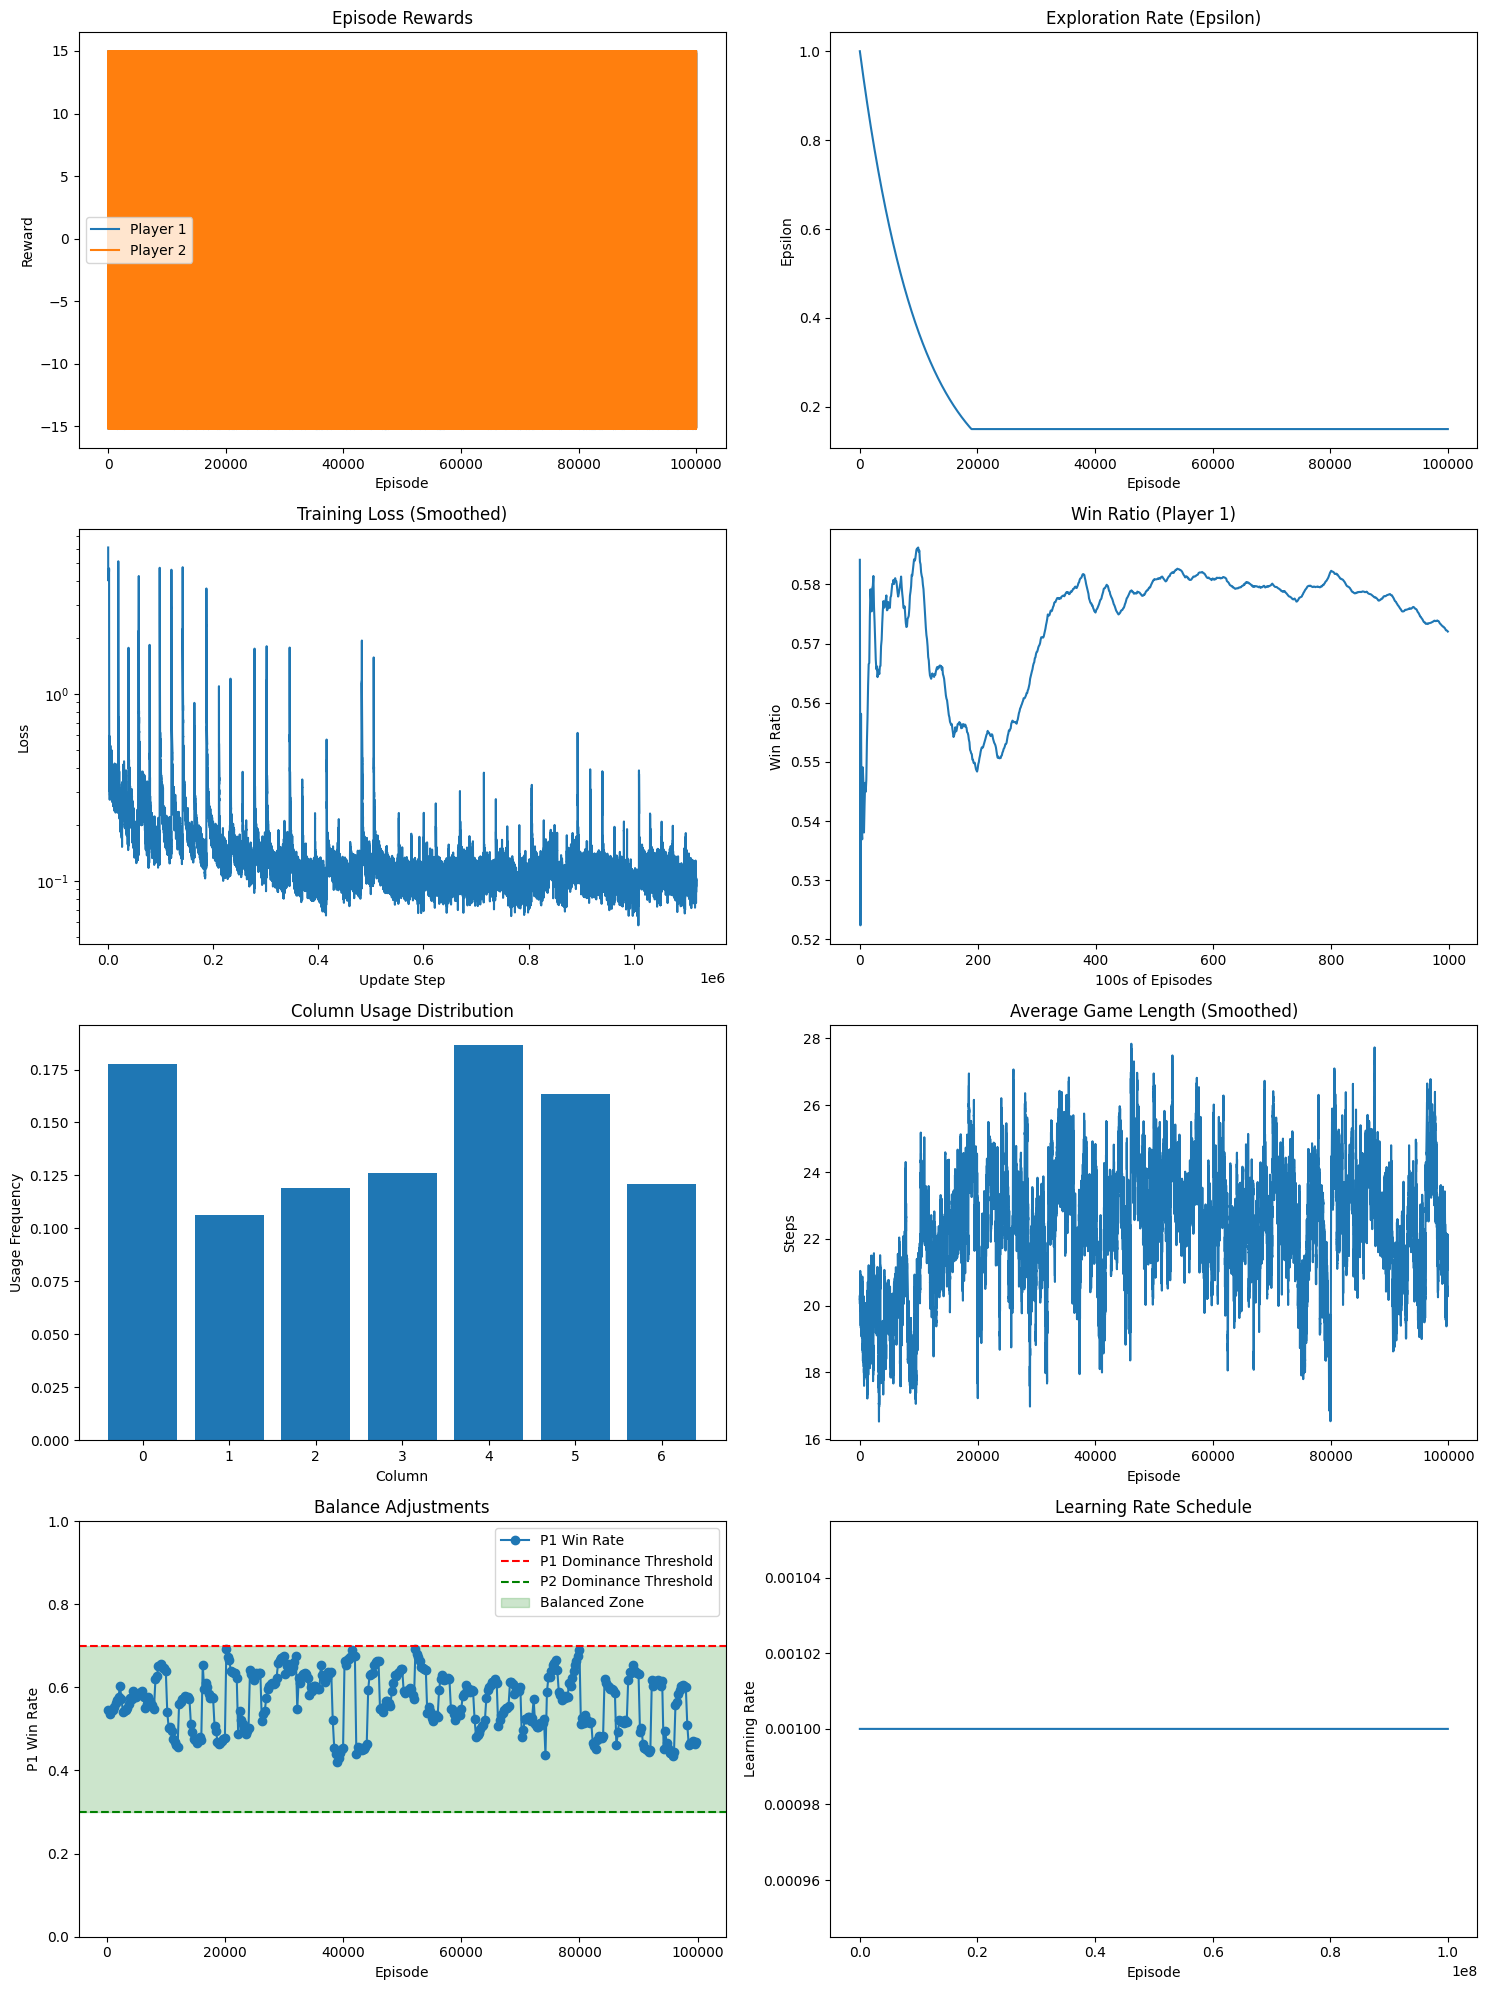

Training Summary at Episode 99999
Player 1 Wins: 57184
Player 2 Wins: 41501
Draws: 1315
Win Ratio: 0.572
Average Game Length: 22.32 steps
Column Usage: [0.17766663 0.10620957 0.11898516 0.12618339 0.18673578 0.16344495
 0.12077452]
Current Epsilon: 0.1500
Recent Average Loss: 0.098893

Balance Adjustment Summary:
----------------------------------------
Total Balance Checks: 99
Total Adjustments Made: 399
  - P1 Boosted: 0 times (0.0%)
  - P2 Boosted: 0 times (0.0%)
  - No Adjustment Needed: 399 times (100.0%)

Most Recent Adjustments:
  Episode 99750: No Adjustment (P1 win rate: 0.47)
  Episode 99500: No Adjustment (P1 win rate: 0.46)
  Episode 99250: No Adjustment (P1 win rate: 0.47)
  Episode 99000: No Adjustment (P1 win rate: 0.46)
  Episode 98750: No Adjustment (P1 win rate: 0.47)
Final Training Summary
Total Episodes: 100000
Player 1 Wins: 57184
Player 2 Wins: 41501
Draws: 1315
Final Win Ratio: 0.572
Average Game Length: 22.32 steps
Final Epsilon: 0.1500


In [22]:
metrics_path="metrics/metrics_final.npy"
metrics = np.load(metrics_path, allow_pickle=True).item()

# Calculate total episodes
total_episodes = len(metrics['episode_rewards_p1'])

# Call your existing plotting function
plot_training_metrics(metrics, total_episodes-1)

# Print summary statistics to console
print("Final Training Summary")
print("="*40)
print(f"Total Episodes: {total_episodes}")
print(f"Player 1 Wins: {metrics['p1_wins']}")
print(f"Player 2 Wins: {metrics['p2_wins']}")
print(f"Draws: {metrics['draws']}")
print(f"Final Win Ratio: {metrics['p1_wins']/total_episodes:.3f}")
print(f"Average Game Length: {np.mean(metrics['avg_game_length']):.2f} steps")
print(f"Final Epsilon: {metrics['epsilon_values'][-1]:.4f}")

### Play

In [29]:
trained_model1 = load_trained_model(path="models/model1_ep10000.pth")
trained_model2 = load_trained_model(path="models/model2_ep10000.pth")
ui = start_connect4_ui(trained_model1, trained_model2, -1)

Loaded model from models/model1_ep10000.pth
Loaded model from models/model2_ep10000.pth


/var/folders/4d/yh24l07s0v7gm5xwwh_dr0mh0000gn/T/ipykernel_42249/2728730580.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=de